# 提示词Agent

[参考链接](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/chatbots/information-gather-prompting.ipynb)

In [6]:
! pip install -U langgraph langchain_openai langchain_core langchain langchain_ai21

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


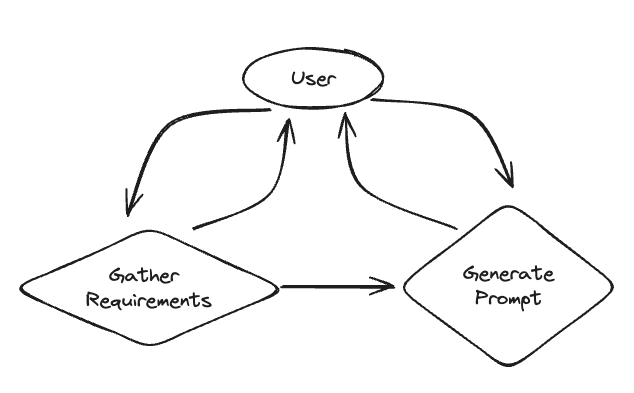

这个将会创建一个生成提示词的agent

In [7]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

from pydantic import BaseModel
import os

load_dotenv()

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME')
)

llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## 生成提示

In [8]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}